# Prediction Goals

## Intro

**Goal:** find a `MinProfitableAccAvg(#ahead)` function.

For:
* `Acc = 0.5 + eps`

...amount gained can be computed by noting that:
* `0.5 + eps` of the time we predict correctly
* `0.5 - eps` of the time me predict incorrectly
* when we predict correctly  win on average `std(#ahead)` (times traded quantity but we can take it to be 1 here)

...so on average we gain:
* `(0.5 + eps) * std - (0.5 - eps) * std = 2 * eps * std`

To make a profit we must gain more than the costs of operating the strategy, which are made up of (times qty, but it's 1):
* a % transction fee: `fee`
* the bid-ask spread: `spread`

So our profit function looks like this:
* `Profit(#ahead, eps) = 2 * eps * std(#ahead) - fee - spread`

So our function needs to find for each `#ahead` the minimump `eps` (searching up to a max) for which `Profit` is 0 (and the accuracy is 0.5 plus that eps ofc).

Ergo:
* `MinProfitableAcc(#ahead) = (fee+spread) / 2*std(#ahead) + 0.5`

## Data loading and setup

We're actually interested of the value of the constant (for one exchange, for a time period) `(fee + spread) / 2` which is named `min_eps_ct` in code. (Under the hypothetical scenario of trading a qty. of 1.)

For Bitstamp exchange at current moment (Oct 2018), this is close to `0.15`.

In [65]:
# PARAMS:
BC5M_FILENAME = './data_clean/btc.300s.cbpro.csv'
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
STOCKS = [
    'sp500',
    'amd',
    'nvda',
    'gbtc',
    'mara',
    'ostk',
    'otiv',
    'riot',
    'sieb',
]
STOCKS_FILENAMES = {s: './data_clean/' + s + '.csv'
                    for s in STOCKS}
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [66]:
# autoreload
%load_ext autoreload
%autoreload 1

# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import os
import sys
from datetime import datetime
import datetime as dtm
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd, Markdown
from IPython.display import Image

%matplotlib inline

%aimport lib.visualization
%aimport lib.helpers
%aimport data_cleanup.util
from lib.visualization import simple_plot
import lib.helpers as helpers

np.set_printoptions(threshold=1000)  # 'nan' == all
pd.set_option('display.max_rows', 1000)

def dmd(s):
    dd(Markdown(s))

> size: 387948


datetime    datetime64[ns]
low                float64
high               float64
open               float64
close              float64
volume             float64
dtype: object

,datetime,low,high,open,close,volume
timestamp,,,,,,
1422745200,2015-01-31 23:00:00,224.51,225.69,225.38,224.51,29.638700
1422745500,2015-01-31 23:05:00,224.00,225.59,224.62,224.00,52.189176
1422745800,2015-01-31 23:10:00,221.99,223.92,223.91,221.99,40.262566
1422746100,2015-01-31 23:15:00,218.00,222.00,222.00,218.00,163.490760
1422746400,2015-01-31 23:20:00,217.11,218.89,217.92,218.22,96.317898


,datetime,low,high,open,close,volume
timestamp,,,,,,
1539128100,2018-10-09 23:35:00,6590.30,6593.48,6591.54,6590.30,17.148190
1539128400,2018-10-09 23:40:00,6586.55,6590.31,6590.31,6589.30,15.269094
1539128700,2018-10-09 23:45:00,6589.29,6589.69,6589.30,6589.48,12.466310
1539129000,2018-10-09 23:50:00,6589.47,6592.81,6589.48,6591.85,14.972801
1539129300,2018-10-09 23:55:00,6589.47,6592.81,6591.84,6589.48,31.305392


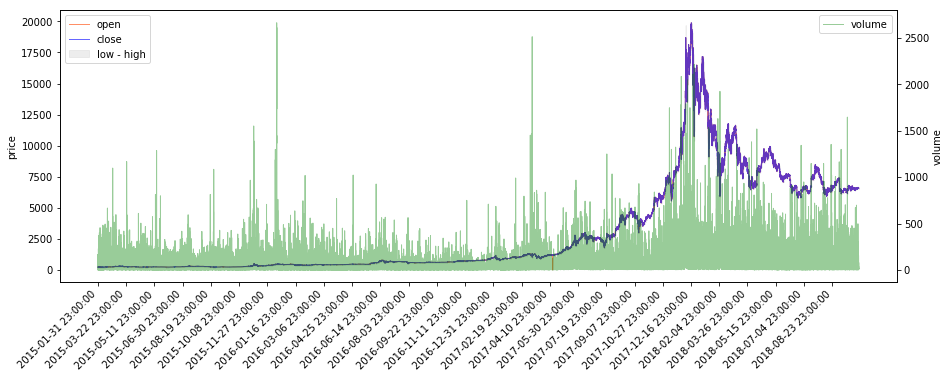

In [4]:
data5m = pd.read_csv(
    BC5M_FILENAME,
    index_col='timestamp',
    parse_dates=['datetime']
)
print('> size:', len(data5m))
dd(data5m.dtypes)
dd(data5m.head())
dd(data5m.tail())
simple_plot(data5m, xticks_span=30 * 24 * 60 // 3)

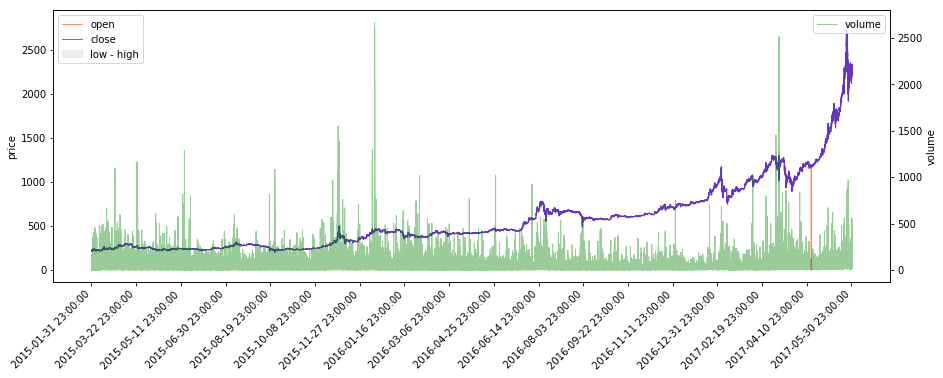

In [5]:
simple_plot(data5m.loc[:helpers.date_str_to_ts('2017-06-01')],
            xticks_span=30 * 24 * 60 // 3)

> size: 1351


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0
2015-02-02,238.0,214.8,242.0,214.8,6.42,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0
2015-02-04,227.0,227.4,231.0,220.0,14.31,0
2015-02-05,217.0,227.0,228.9,213.6,4.31,0


,close,open,high,low,volume,missing
datetime,,,,,,
2018-10-09,6588.8,6604.8,6623.1,6553.1,2.25,0
2018-10-10,6517.5,6588.7,6589.8,6400.0,5.18,0
2018-10-11,6161.0,6517.5,6518.4,6067.0,9.62,0
2018-10-12,6184.9,6152.8,6238.3,6109.8,3.25,0
2018-10-13,6195.0,6180.8,6214.1,6168.8,2.27,0


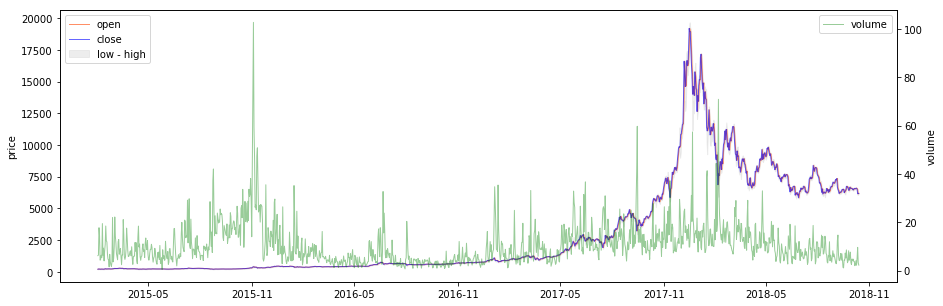

In [6]:
data24h = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime'])
print('> size:', len(data24h))
dd(data24h.dtypes)
dd(data24h.head())
dd(data24h.tail())
simple_plot(data24h, show_xlabels=False)

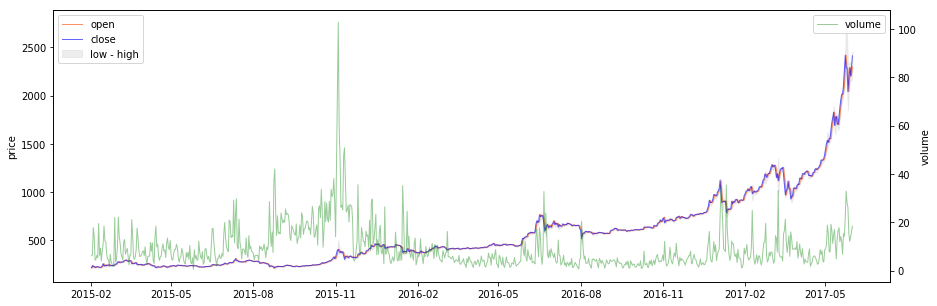

In [7]:
simple_plot(data24h.loc[:'2017-06-01'], show_xlabels=False)

In [8]:
close5m = data5m['close'].values
close24h = data24h['close'].values

In [68]:
stocks_data = {}
for stock, filename in STOCKS_FILENAMES.items():
    data = pd.read_csv(
        filename,
        index_col='datetime',
        parse_dates=['datetime']
    )
    data = data[data.index >= '2015-02-28']
    data['weekday'] = data.index.dayofweek
    stocks_data[stock] = data
#     print("\n\n---------")
#     print("> stock %s: %d data points" % (stock.upper(), len(data)))
#     print("  from %s to %s" % (data.iloc[0].name, data.iloc[-1].name))
#     dd(data.head(1))
#     simple_plot(data, show_xlabels=False)
#     plt.show()

## Visualize stdev

In [9]:
def stdev(data, at):
    out = np.zeros(len(data) - at, dtype=np.float64)
    for i in xrange(len(data) - at):
        out[i] = data[i: i + at].std()
    return out

def plot_stdev(data, xs, at):
    fig = plt.figure(figsize=(10, 3), facecolor='white')
    stdevs = stdev(data, at)
    avg = np.average(stdevs)
    plt.plot(xs, stdevs, color='c', linewidth=1, label='$\sigma(%d)$' % at)
    plt.plot(xs, [avg] * len(xs), color='m', linewidth=2, label='avg. $\sigma = %.2f$' % avg)
    plt.legend()
    print("average: %f" % avg)

In [10]:
def min_acc_by_ahead(data, ahead, min_eps_ct=0.15):
    out = np.zeros(ahead, dtype=np.float64)
    zeros = 0
    for i in xrange(len(data) - ahead):
        for j in xrange(3, ahead):
            std = data[i: i + j].std()
            if std == 0:
                zeros += 1
                continue
            out[j] += min_eps_ct / std
    out[3:] /= len(data) - ahead - zeros
    print("    (%d stdevs of 0 found)" % zeros)
    out += 0.5
    return out

def plot_min_acc_by_ahead(data, ahead, min_eps_ct=0.15, mark_at=100):
    min_accs = min_acc_by_ahead(data, ahead, 0.15)
    xs = np.arange(70, len(min_accs))
    plt.figure(figsize=(15, 5))
    plt.plot(xs, min_accs[70:], color='b', linewidth=1)
#     plt.plot(xs, np.ones(len(xs)) * min_accs[mark_at], color='r', linewidth=1)
#     plt.axvline(x=mark_at, color='r', linewidth=0.5)
#     print("@ %d: %f" % (mark_at, min_accs[mark_at]))

average: 29.574533


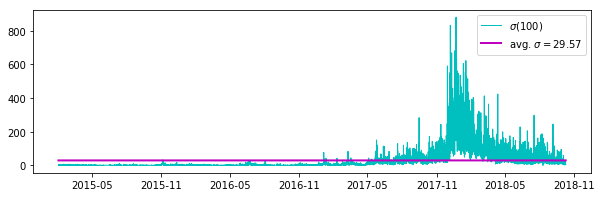

In [11]:
plot_stdev(close5m, data5m['datetime'].values[:-100], 100)

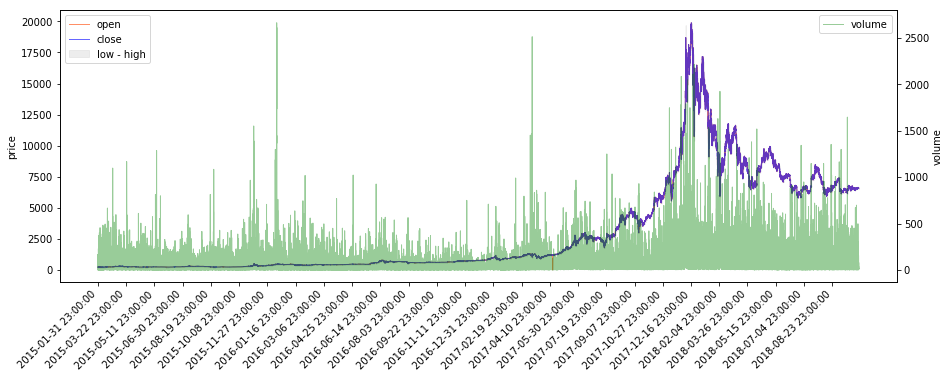

In [12]:
simple_plot(data5m, xticks_span=30 * 24 * 60 // 3)

average: 143.096071


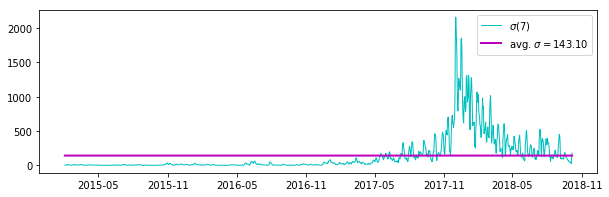

In [13]:
plot_stdev(close24h, data24h.index.values[:-7], at=7)

## `Min-Acc(#ahead)`

In [62]:
def plot_acc_by_ahead_report(
    data, n_ahead, start_at=3, min_eps_ct=0.15, print_at=[],
    fig_size=(15, 5), fig_title=''
):
    min_accs = min_acc_by_ahead(data, n_ahead, min_eps_ct)
    xs = np.arange(start_at, len(min_accs))
    plt.figure(figsize=fig_size)
    if fig_title:
        plt.title(fig_title)
    plt.plot(xs, min_accs[start_at:], color='b', linewidth=1)
    plt.show()
    txt = []
    print("Min profitable DACC by distance ahead:")
    txt.append("| %s |\n" % " | ".join(map(str, print_at)))
    txt.append("|" + "|".join(["-"] * len(print_at)) + "|\n|")
    for i in print_at:
        txt.append(" %.2f%% |" % (min_accs[i] * 100))
    txt = "".join(txt)
    dmd(txt)
    print("> table markdown:\n %s" % txt)

In [43]:
print(one)

u'**test**'

    (0 stdevs of 0 found)
Min acc at 7: 0.5167313590715515
Min acc at 6: 0.5188842871727539
Min acc at 5: 0.5223033374369233
Min acc at 4: 0.5277445477717878
Min acc at 3: 0.5410135624970198


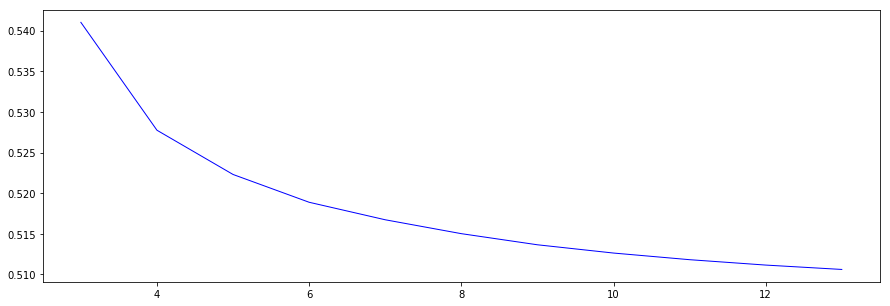

In [21]:
min_accs = min_acc_by_ahead(close24h, 14, 0.15)
xs = np.arange(3, len(min_accs))
plt.figure(figsize=(15, 5))
plt.plot(xs, min_accs[3:], color='b', linewidth=1)
print("Min acc at 7:", min_accs[7])
print("Min acc at 6:", min_accs[6])
print("Min acc at 5:", min_accs[5])
print("Min acc at 4:", min_accs[4])
print("Min acc at 3:", min_accs[3])

    (0 stdevs of 0 found)


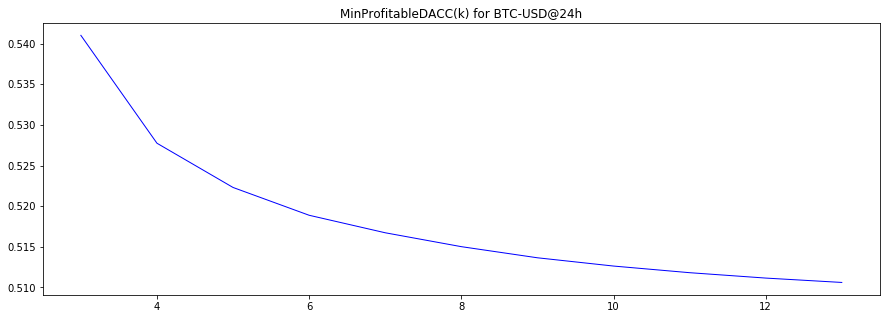

Min profitable DACC by distance ahead:


| 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 54.10% | 52.77% | 52.23% | 51.89% | 51.67% |

> table markdown:
 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 54.10% | 52.77% | 52.23% | 51.89% | 51.67% |


In [63]:
plot_acc_by_ahead_report(
    close24h,
    n_ahead=14,
    start_at=3,
    min_eps_ct=0.15,
    print_at=range(3, 8),
    fig_title='MinProfitableDACC(k) for BTC-USD@24h'
)

    (27053 stdevs of 0 found)


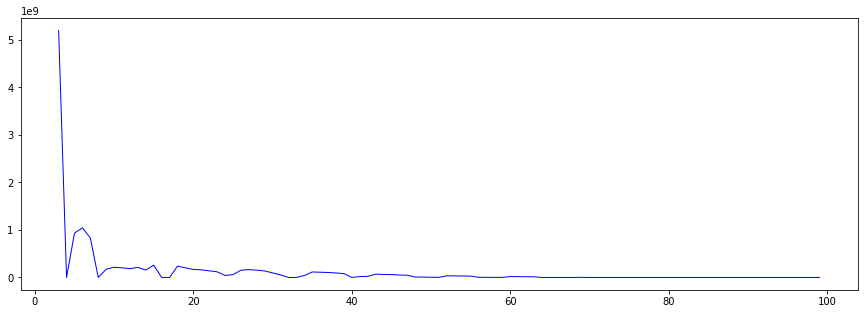

In [36]:
min_accs_5m_all = min_acc_by_ahead(close5m, 100, 0.15)
xs = np.arange(3, len(min_accs_5m_all))
plt.figure(figsize=(15, 5))
plt.plot(xs, min_accs_5m_all[3:], color='b', linewidth=1)

    (27053 stdevs of 0 found)


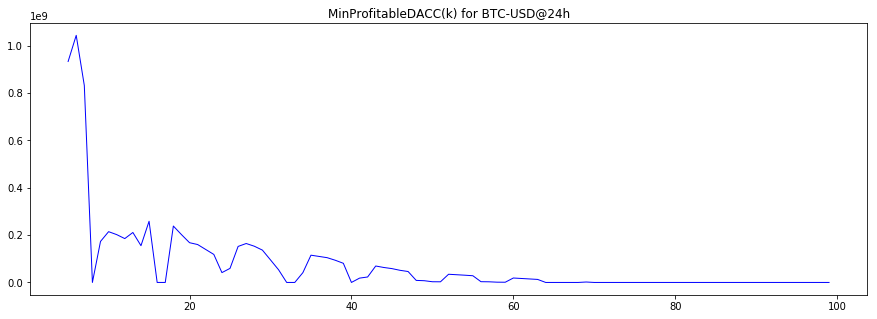

Min profitable DACC at 50: 297128307.00%
Min profitable DACC at 75: 62.55%


IndexError: index 100 is out of bounds for axis 0 with size 100

In [27]:
plot_acc_by_ahead_report(
    close5m,
    n_ahead=100,
    start_at=5,
    min_eps_ct=0.15,
    print_at=[50, 75, 100],
    fig_title='MinProfitableDACC(k) for BTC-USD@24h'
)

    (28 stdevs of 0 found)


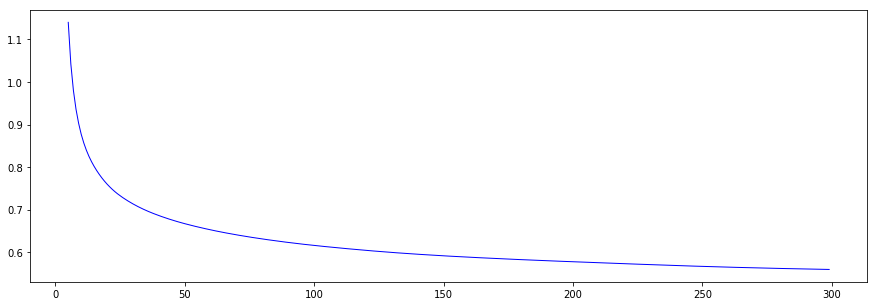

In [44]:
min_accs_5m_0 = min_acc_by_ahead(close5m[:5000], 300, 0.15)
xs = np.arange(5, len(min_accs_5m_0))
plt.figure(figsize=(15, 5))
plt.plot(xs, min_accs_5m_0[5:], color='b', linewidth=1)

In [65]:
print("0) Min acc at 100:", min_accs_5m_0[100])
print("0) Min acc at 75:", min_accs_5m_0[75])
print("0) Min acc at 50:", min_accs_5m_0[50])
print("0) Min acc at 288:", min_accs_5m_0[50])

0) Min acc at 100: 0.6158034626074648
0) Min acc at 75: 0.6356426766737645
0) Min acc at 50: 0.6669502480057993
0) Min acc at 288: 0.6669502480057993


    (194 stdevs of 0 found)
1) Min acc at 100: 0.5937151835867165


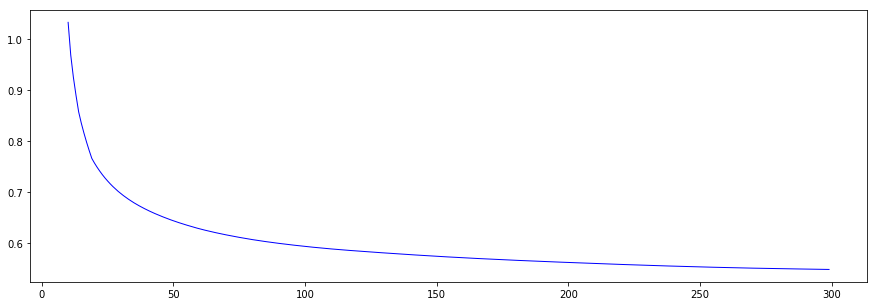

In [48]:
min_accs_5m_1 = min_acc_by_ahead(close5m[100000:105000], 300, 0.15)
xs = np.arange(10, len(min_accs_5m_1))
plt.figure(figsize=(15, 5))
plt.plot(xs, min_accs_5m_1[10:], color='b', linewidth=1)
print("1) Min acc at 100:", min_accs_5m_1[100])

In [64]:
print("1) Min acc at 75:", min_accs_5m_1[75])
print("1) Min acc at 50:", min_accs_5m_1[50])
print("1) Min acc at 288:", min_accs_5m_1[288])

1) Min acc at 75: 0.6114369842930185
1) Min acc at 50: 0.6438928083602861
1) Min acc at 288: 0.5494069523274695


    (63 stdevs of 0 found)
2) Min acc at 100: 0.5279133351296853
2) Min acc at 75: 0.5335452209607481
2) Min acc at 50: 0.5433551689019436
2) Min acc at 288: 0.5149457077091955


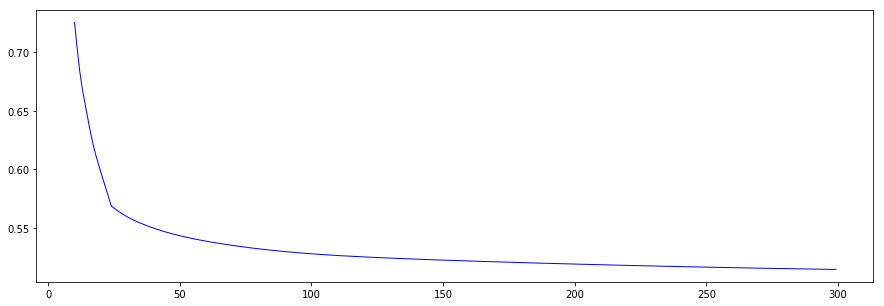

In [61]:
min_accs_5m_2 = min_acc_by_ahead(close5m[200000:205000], 300, 0.15)
xs = np.arange(10, len(min_accs_5m_2))
plt.figure(figsize=(15, 5))
plt.plot(xs, min_accs_5m_2[10:], color='b', linewidth=1)
print("2) Min acc at 100:", min_accs_5m_2[100])
print("2) Min acc at 75:", min_accs_5m_2[75])
print("2) Min acc at 50:", min_accs_5m_2[50])
print("2) Min acc at 288:", min_accs_5m_2[288])

## Conclusions

First, the high variability of the standard deviation tells us that we shouldn't have much trust in this model. (An empirical backtesting of an actual trading model using our predictors on historical trading data should probably be used instead for real-life scenarios. But such a model could get quite complicated since an actual **trading strategy** involves much more than the **predictive model**, so we will use this theoricat model for now.)

Also, the 24h resolution data looks very different from the 5min resolution one. Trying to unify these results would require too much theoretical assumptions, so we will treat them separately.

### 24 h data

Data at less than 2 point prediction into the future is too noisy.

```
Min acc at 7: 0.5167313590715515
Min acc at 5: 0.5223033374369233
Min acc at 4: 0.5277445477717878
Min acc at 3: 0.5410135624970198
```

We might assume that a >60% at 1 day ahead accurate model has chance of driving a profitable strategy. Using 5min resolution data (see below) to calculate required accuracy for a 1 day ahead prediction could day that even >55% can be enough.

Taking an average, >57.5% at one day ahead could be taken as the minimal accuracy that has a change of driving a profitable trading strategy.

At 7 days ahead it might be enough to go >52%.

### 5min data

We look at 3 zones of the dataset since we know the stdev varies a lot with time.

```
Around start:
0) Min acc at 100: 0.6158034626074648
0) Min acc at 75: 0.6356426766737645
0) Min acc at 50: 0.6669502480057993
0) Min acc at 288: 0.6669502480057993

Around position 100K:
1) Min acc at 100: 0.5937151835867165
1) Min acc at 75: 0.6114369842930185
1) Min acc at 50: 0.6438928083602861
1) Min acc at 288: 0.5494069523274695

Around position 200K:
2) Min acc at 100: 0.5279133351296853
2) Min acc at 75: 0.5335452209607481
2) Min acc at 50: 0.5433551689019436
2) Min acc at 288: 0.5149457077091955
```

Since looking at the most recent data might be too optimistic, we'd regard the middle reange instead, and consider these target:

* at 50 points (4.17h) ahead: >64%
* at 75 points (6.25h) ahead: >61%
* at 100 points (8.33h) ahead: >59%
* at 288 points (1 day) ahead: >55%

## Systematic approach

    (0 stdevs of 0 found)


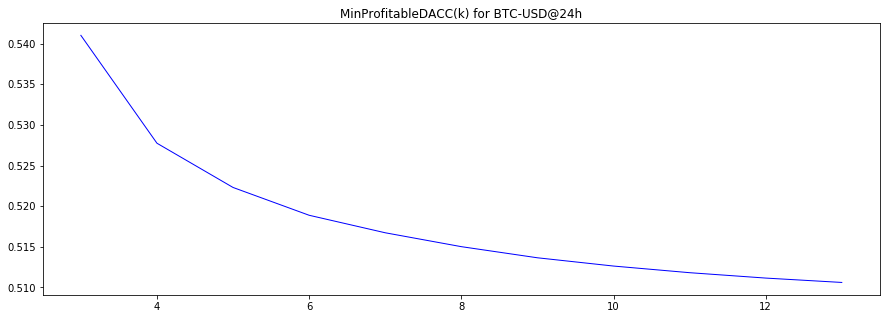

Min profitable DACC by distance ahead:


| 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 54.10% | 52.77% | 52.23% | 51.89% | 51.67% |

> table markdown:
 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 54.10% | 52.77% | 52.23% | 51.89% | 51.67% |


In [64]:
plot_acc_by_ahead_report(
    close24h,
    n_ahead=14,
    start_at=3,
    min_eps_ct=0.15,
    print_at=range(3, 8),
    fig_title='MinProfitableDACC(k) for BTC-USD@24h'
)

    (0 stdevs of 0 found)


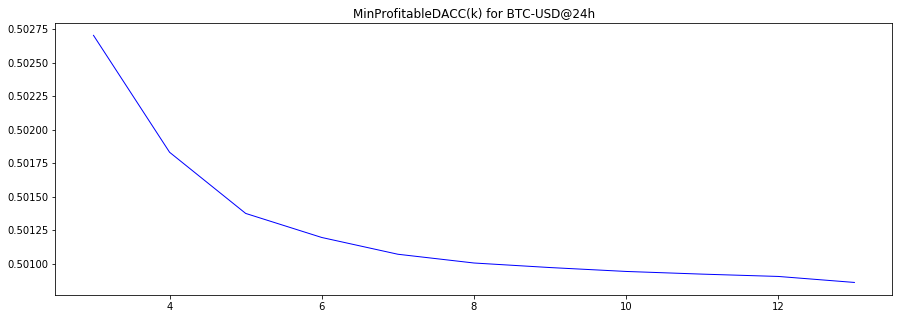

Min profitable DACC by distance ahead:


| 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 50.27% | 50.18% | 50.14% | 50.12% | 50.11% |

> table markdown:
 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 50.27% | 50.18% | 50.14% | 50.12% | 50.11% |


In [75]:
plot_acc_by_ahead_report(
    close24h[-3 * 30:],
    n_ahead=14,
    start_at=3,
    min_eps_ct=0.15,
    print_at=range(3, 8),
    fig_title='MinProfitableDACC(k) for BTC-USD@24h'
)

    (15777 stdevs of 0 found)


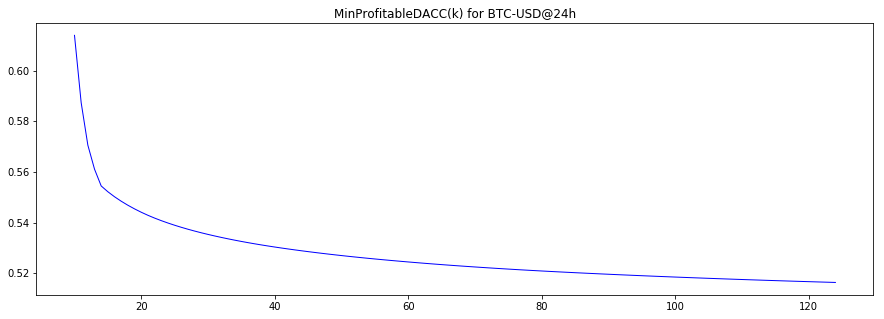

Min profitable DACC by distance ahead:


| 50 | 75 | 100 |
|-|-|-|
| 52.70% | 52.16% | 51.85% |

> table markdown:
 | 50 | 75 | 100 |
|-|-|-|
| 52.70% | 52.16% | 51.85% |


In [78]:
plot_acc_by_ahead_report(
    close5m[-3 * 30 * 24 * 60 // 5: ],
    n_ahead=125,
    start_at=10,
    min_eps_ct=0.15,
    print_at=[50, 75, 100],
    fig_title='MinProfitableDACC(k) for BTC-USD@24h'
)

    (29002 stdevs of 0 found)


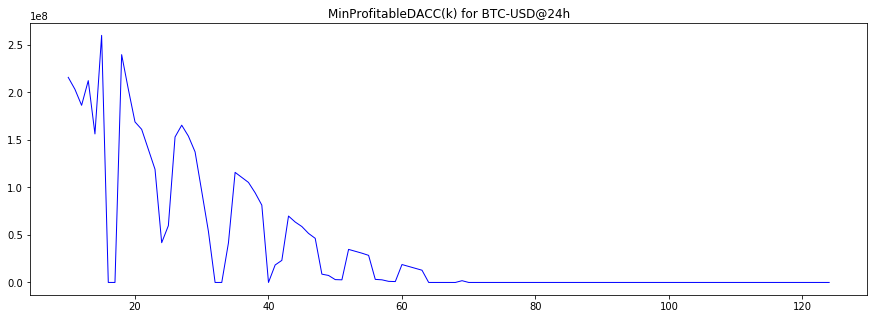

Min profitable DACC by distance ahead:


| 50 | 75 | 100 |
|-|-|-|
| 298762913.61% | 62.61% | 60.67% |

> table markdown:
 | 50 | 75 | 100 |
|-|-|-|
| 298762913.61% | 62.61% | 60.67% |


In [79]:
plot_acc_by_ahead_report(
    close5m,
    n_ahead=125,
    start_at=10,
    min_eps_ct=0.15,
    print_at=[50, 75, 100],
    fig_title='MinProfitableDACC(k) for BTC-USD@24h'
)

    (0 stdevs of 0 found)


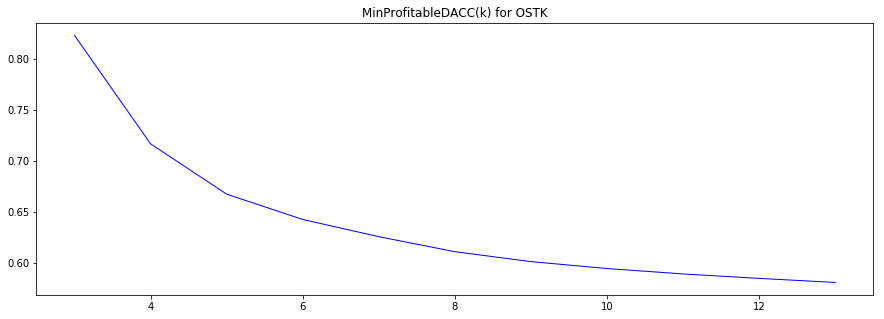

Min profitable DACC by distance ahead:


| 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 82.27% | 71.67% | 66.75% | 64.28% | 62.60% |

> table markdown:
 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 82.27% | 71.67% | 66.75% | 64.28% | 62.60% |
    (0 stdevs of 0 found)


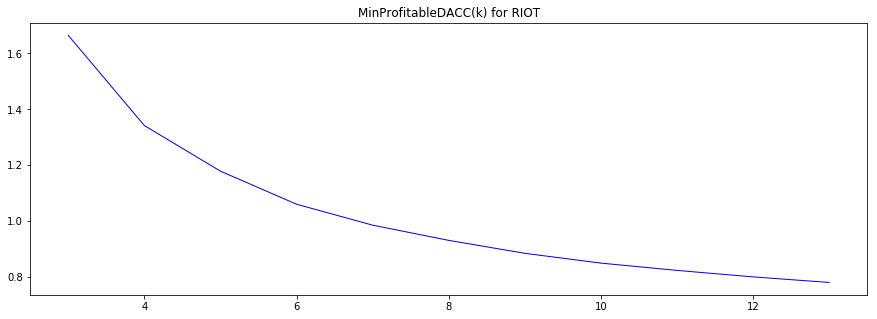

Min profitable DACC by distance ahead:


| 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 166.44% | 134.20% | 117.90% | 106.08% | 98.60% |

> table markdown:
 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 166.44% | 134.20% | 117.90% | 106.08% | 98.60% |
    (0 stdevs of 0 found)


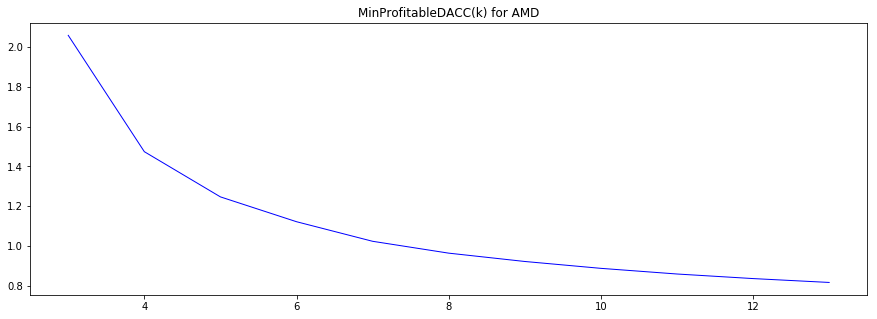

Min profitable DACC by distance ahead:


| 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 205.77% | 147.38% | 124.70% | 112.23% | 102.41% |

> table markdown:
 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 205.77% | 147.38% | 124.70% | 112.23% | 102.41% |
    (2 stdevs of 0 found)


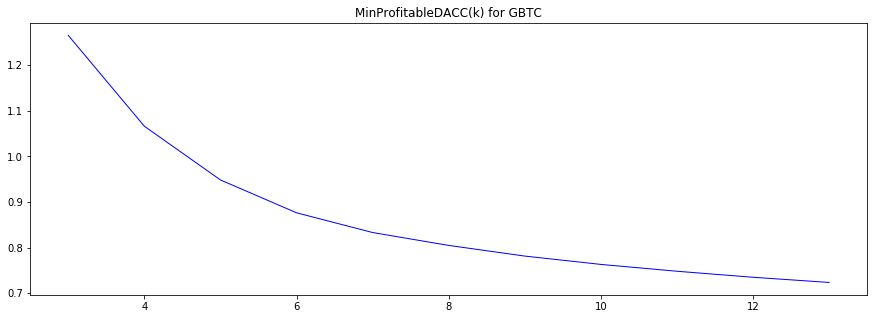

Min profitable DACC by distance ahead:


| 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 126.53% | 106.61% | 94.83% | 87.63% | 83.30% |

> table markdown:
 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 126.53% | 106.61% | 94.83% | 87.63% | 83.30% |
    (0 stdevs of 0 found)


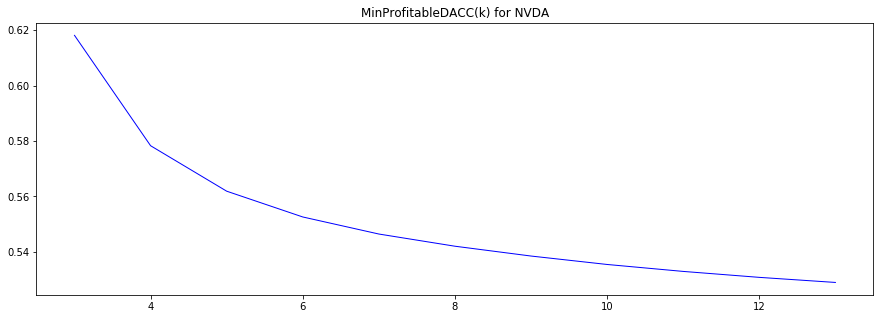

Min profitable DACC by distance ahead:


| 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 61.81% | 57.83% | 56.19% | 55.25% | 54.64% |

> table markdown:
 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 61.81% | 57.83% | 56.19% | 55.25% | 54.64% |
    (0 stdevs of 0 found)


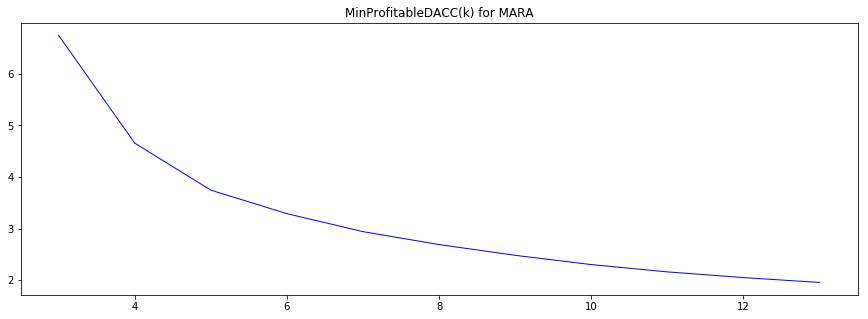

Min profitable DACC by distance ahead:


| 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 674.50% | 465.57% | 374.39% | 328.82% | 293.91% |

> table markdown:
 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 674.50% | 465.57% | 374.39% | 328.82% | 293.91% |
    (14 stdevs of 0 found)


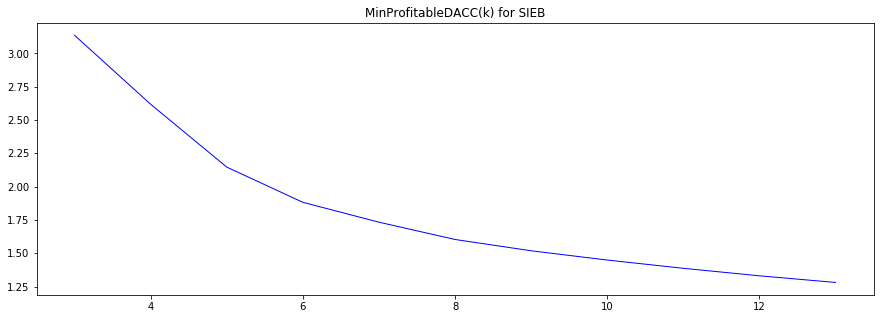

Min profitable DACC by distance ahead:


| 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 313.51% | 261.77% | 214.61% | 188.20% | 173.28% |

> table markdown:
 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 313.51% | 261.77% | 214.61% | 188.20% | 173.28% |
    (0 stdevs of 0 found)


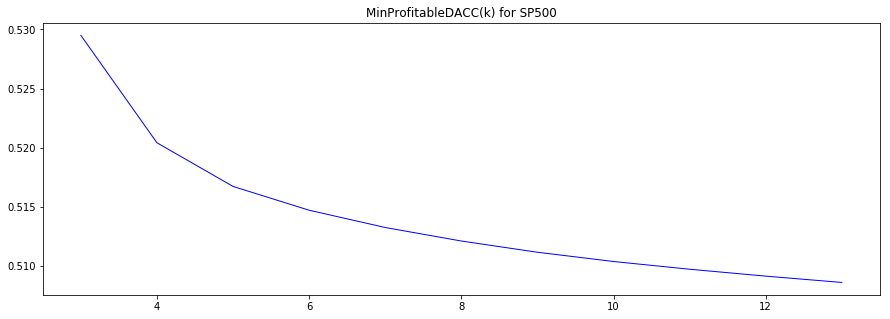

Min profitable DACC by distance ahead:


| 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 52.95% | 52.04% | 51.67% | 51.47% | 51.33% |

> table markdown:
 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 52.95% | 52.04% | 51.67% | 51.47% | 51.33% |
    (2 stdevs of 0 found)


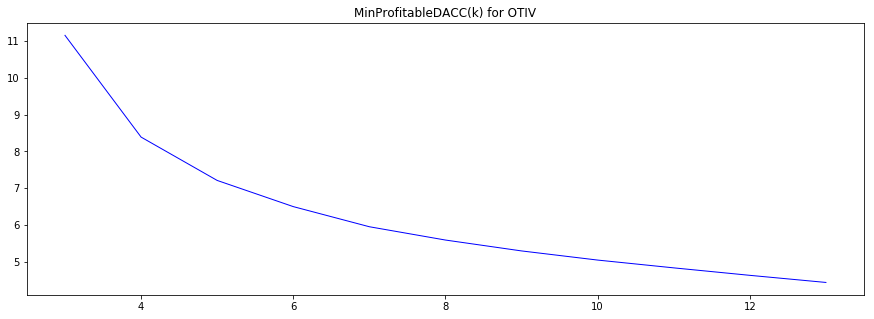

Min profitable DACC by distance ahead:


| 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 1115.50% | 838.94% | 721.12% | 649.97% | 595.24% |

> table markdown:
 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|
| 1115.50% | 838.94% | 721.12% | 649.97% | 595.24% |


In [72]:
for symbol, data in stocks_data.items():
    plot_acc_by_ahead_report(
        data['close'].values[-300:],
        n_ahead=14,
        start_at=3,
        min_eps_ct=0.15,
        print_at=range(3, 8),
        fig_title='MinProfitableDACC(k) for %s' % symbol.upper()
    )